In [ ]:
#default_exp peakpuzzle

# The peak pattern puzzle 

> Matching peak patterns 

In [ ]:
#hide 
%load_ext autoreload
%autoreload 2 
%matplotlib notebook

In [ ]:
# hide 
import os
os.chdir('/home/frank/Work/Projecten/DoRe/viz/raw_nmf')

In the previous steps we have computed the hotmax spectra and located their individual peaks. All this preliminary work was needed to arrive at the central problem of MA-XRF analysis: solving the peak pattern puzzle. For each individual hotmax spectrum I would like to explain the presence of all peaks above the Poison noise level. 

Before trying to assign peaks to the presence of specific elements in the scanned object, one should identify instrumental peaks that result from the physics of the instrument sensor or Rhodium anode.  

<IPython.core.display.Javascript object>


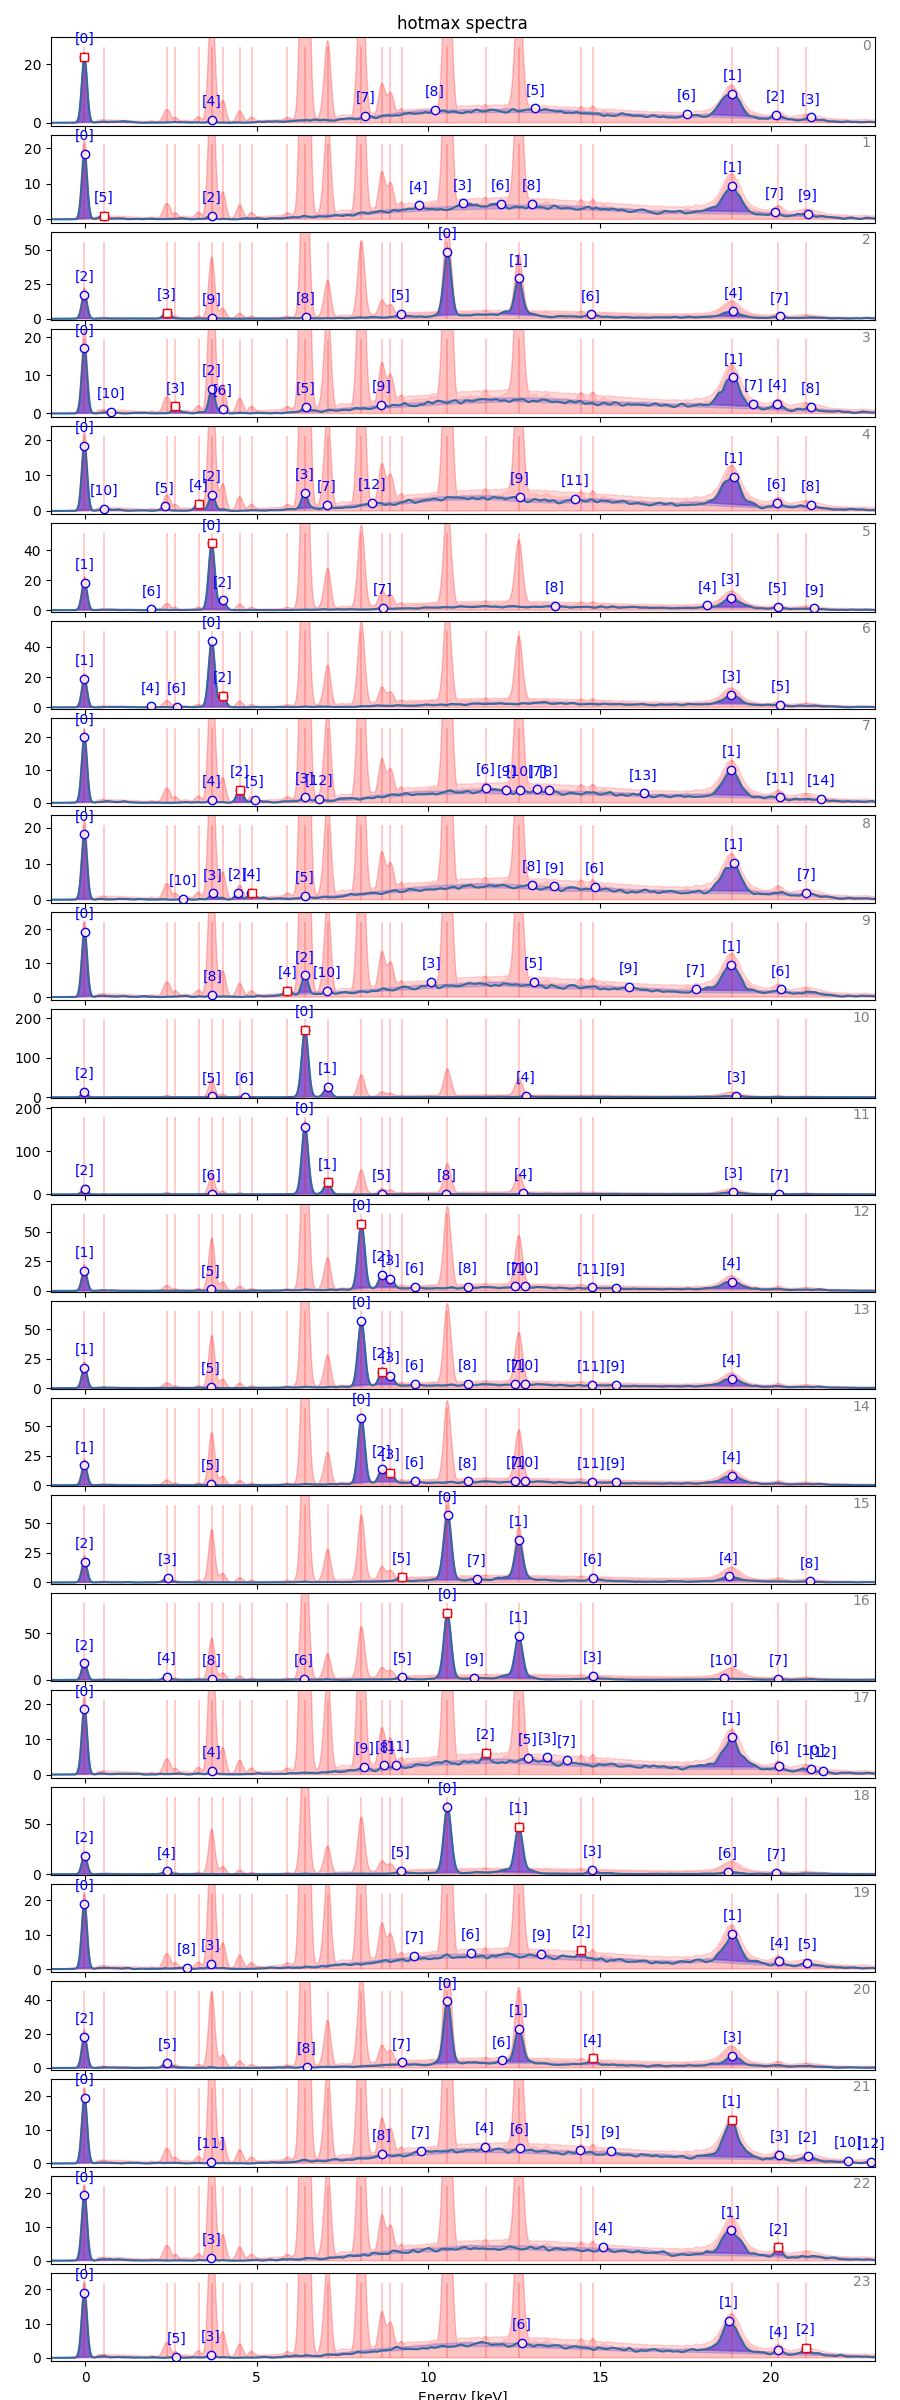

In [ ]:
from maxrf4u import HotmaxAtlas 

hma = HotmaxAtlas('RP-T-1898-A-3689.datastack')

hma.plot_spectra()

Or we can plot a single spectrum with `HotmaxAtlas.plot_spectrum(<nr>)` to inspect a specific hotmax spectrum. 

<IPython.core.display.Javascript object>


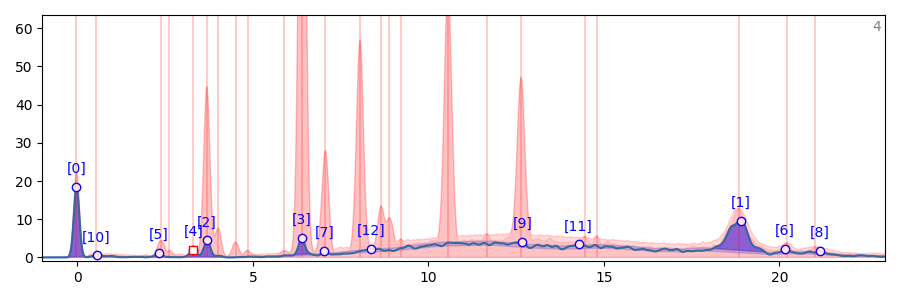

In [ ]:
hma.plot_spectrum(4, headspace=3);

Now we can start to 'explain away' all peaks... 

**To be continued...**

In [ ]:
hma = HotmaxAtlas('RP-T-1898-A-3689.datastack')

<IPython.core.display.Javascript object>


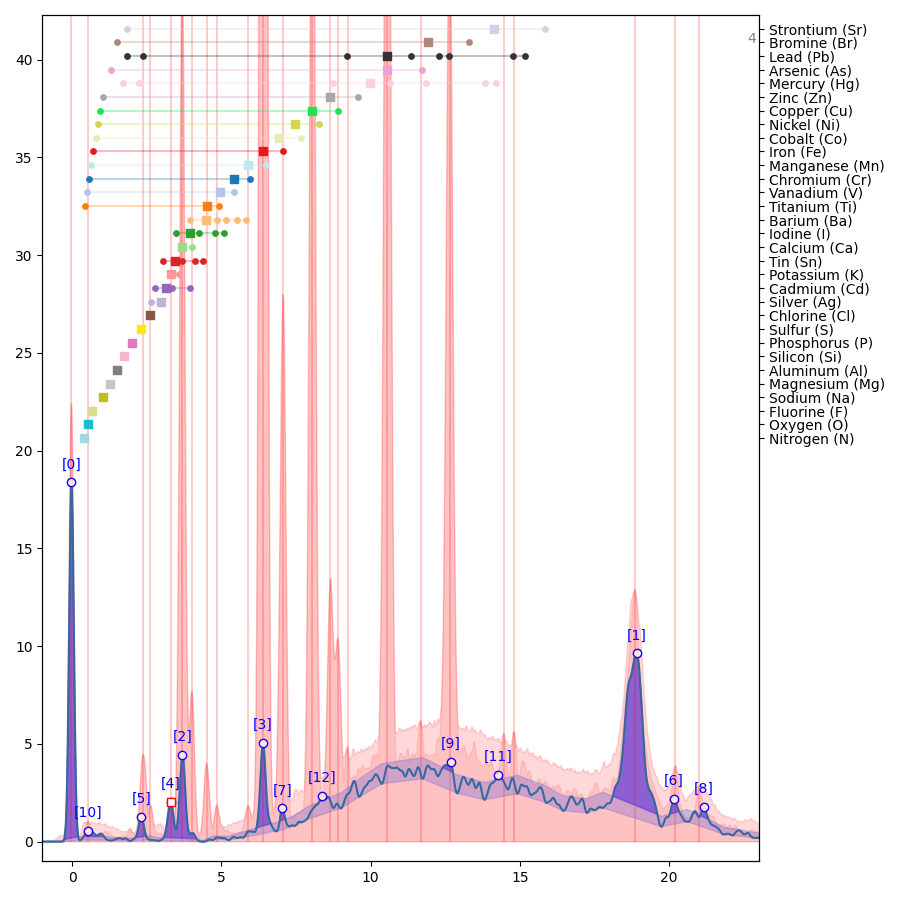

In [ ]:
fig, ax = plt.subplots(figsize=[9, 9])

n = 4 
ann_list = hma.plot_spectrum(n, ax=ax, headspace=2)

eoi_ptrns = get_patterns(eoi)

twax = ax.twinx()
plot_patterns(eoi_ptrns, ax=twax)

## Module `maxrf4u.peakpuzzle.py`

In [ ]:
#export 

from maxrf4u import HotmaxAtlas 
import re 
import matplotlib.pyplot as plt 
import matplotlib.cm as cm 
import mendeleev
import moseley as mos
import numpy as np 


# all elements 
all_elements = ['#H', '#He', '#Li', '#Be', '#B', '#C', 'N', 'O', 'F', '#Ne', 'Na', 'Mg', 'Al', 
                'Si', 'P', 'S', 'Cl', '#Ar', 'K', 'Ca', '#Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 
                'Co', 'Ni', 'Cu', 'Zn', '#Ga', '#Ge', 'As', '#Se', 'Br', '#Kr', '#Rb', 'Sr', 
                '#Y', '#Zr', '#Nb', '#Mo', '#Tc', '#Ru', '#Rh', '#Pd', 'Ag', 'Cd', '#In', 'Sn', 
                '#Sb', '#Te', 'I', '#Xe', '#Cs', 'Ba', '#La', '#Hf', '#Ta', '#W', '#Re', '#Os', 
                '#Ir', '#Pt', '#Au', 'Hg', '#Tl', 'Pb', '#Bi', '#Po', '#At', '#Rn', '#Fr', '#Ra', 
                '#Ac', '#Rf', '#Db', '#Sg', '#Bh', '#Hs', '#Mt', '#Ds', '#Rg', '#Cn', '#Nh', 
                '#Fl', '#Mc', '#Lv', '#Ts', '#Og']

# elements of interest (to me) 
eoi = [e for e in all_elements if not '#' in e]


def get_patterns(elements, tube_keV=22): 
    '''Returns sorted pattern dict list, according to alpha peak energy. '''
    
    ptrn_dict_list = []
    
    for elem in elements: 

        spectrum = mos.XFluo(elem, tube_keV=tube_keV, min_prom=0.01)

        peak_order = np.argsort(spectrum.peak_intensities)[::-1]

        alpha_keV = spectrum.peak_energies[peak_order][0]
        peaks_x = spectrum.peak_energies[peak_order]
        peaks_y = spectrum.peak_intensities[peak_order]
        
        peaks_xy = np.c_[peaks_x, peaks_y] 
        
        color = colorize(elem)
        
        name = mendeleev.element(elem).name
        
        ptrn_dict = {'elem': elem, 'name': name, 'peaks_xy': peaks_xy, 'color': color}
        
        ptrn_dict_list.append(ptrn_dict)
        
    # sort according to alpha energy     
    alpha_keVs = [p['peaks_xy'][0, 0] for p in ptrn_dict_list]        
    indices = np.argsort(alpha_keVs) 
    
    ptrn_list = [ptrn_dict_list[i] for i in indices]
        
    return ptrn_list  

def colorize(elem=None, eoi=None): 
    '''Pick fixed color from nice color map for elements of interest. '''
    
    if eoi is None: 
    
        # select elements of interest 
        all_elements = ['#H', '#He', '#Li', '#Be', '#B', '#C', 'N', 'O', 'F', '#Ne', 'Na', 'Mg', 'Al', 
                        'Si', 'P', 'S', 'Cl', '#Ar', 'K', 'Ca', '#Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 
                        'Co', 'Ni', 'Cu', 'Zn', '#Ga', '#Ge', 'As', '#Se', 'Br', '#Kr', '#Rb', 'Sr', 
                        '#Y', '#Zr', '#Nb', '#Mo', '#Tc', '#Ru', '#Rh', '#Pd', 'Ag', 'Cd', '#In', 'Sn', 
                        '#Sb', '#Te', 'I', '#Xe', '#Cs', 'Ba', '#La', '#Hf', '#Ta', '#W', '#Re', '#Os', 
                        '#Ir', '#Pt', '#Au', 'Hg', '#Tl', 'Pb', '#Bi', '#Po', '#At', '#Rn', '#Fr', '#Ra', 
                        '#Ac', '#Rf', '#Db', '#Sg', '#Bh', '#Hs', '#Mt', '#Ds', '#Rg', '#Cn', '#Nh', 
                        '#Fl', '#Mc', '#Lv', '#Ts', '#Og']

        eoi = [e for e in all_elements if not '#' in e] 
        
    # tab20x2 color map 
    tab20 = cm.tab20(np.arange(20))[:,0:3]
    colors = np.r_[tab20[::-1], tab20[::-1]**0.6]
    
    # custom 
    special_colors = {'Pb': (0.2, 0.2, 0.2), 
                      'Cu': (0.1, 0.9, 0.3), 
                      'Fe': (0.9, 0.1, 0.1), 
                      'S': (1.0, 0.9, 0.1)} 
    
    for e in special_colors.keys(): 
        colors[eoi.index(e)] = special_colors[e]
        
    if elem is not None: 
        assert elem in eoi, f'Element not in: {eoi}'
        colors = colors[eoi.index(elem)]
    
    return colors 
       


def plot_patterns(ptrn_list, ax=None): 
    
    n_ptrns = len(ptrn_list)
    
    elements = [p['elem'] for p in ptrn_list]
    element_labels = [f'{mendeleev.element(e).name} ({e})' for e in elements]
    
    tab20 = cm.tab20(np.arange(20))[:,0:3]
    colors = np.r_[tab20[::-1], tab20[::-1]**0.6]
    
    
    special_colors = {'Pb': (0.2, 0.2, 0.2), 
                      'Cu': (0.1, 0.9, 0.3), 
                      'Fe': (0.9, 0.1, 0.1), 
                      'S': (1.0, 0.9, 0.1)} 
    
    for elem in special_colors.keys(): 
        if elem in elements: 
            colors[elements.index(elem)] = special_colors[elem]
       
    if ax is None: 
        
        fig, ax = plt.subplots(figsize=[9, 8])#0.5*n_ptrns])
        
    for i, ptrn in enumerate(ptrn_list): 

        peaks_x, peaks_y = ptrn['peaks_xy'].T

        left_x = min(peaks_x)
        right_x = max(peaks_x)

        ones = np.ones_like(peaks_y)

        ax.scatter(peaks_x, i * ones, s=15, color=colors[i]) 
        ax.plot([left_x, right_x], [i, i], color=colors[i], alpha=0.3)
        ax.scatter(peaks_x[0], i, marker='s', s=40, color=colors[i])
            
    ax.set_yticks(range(n_ptrns))        
    ax.set_yticklabels(element_labels) 
    ax.set_ylim([-n_ptrns, n_ptrns])
    
    
    #ax.set_title('Common element peak patterns')
    #ax.set_ylabel('Usual suspects')
    #ax.set_xlabel('Energy [keV]')
    
    plt.tight_layout()
    

In [ ]:
len(eoi)

31

In [ ]:
get_patterns(['Fe'])

[{'elem': 'Fe',
  'name': 'Iron',
  'peaks_xy': array([[6.3941971 , 1.        ],
         [7.05452726, 0.13507831],
         [0.70435218, 0.02822656]]),
  'color': array([0.9, 0.1, 0.1])}]

In [ ]:
ptrn_list = get_patterns(eoi)

Let's plot these patterns

<IPython.core.display.Javascript object>


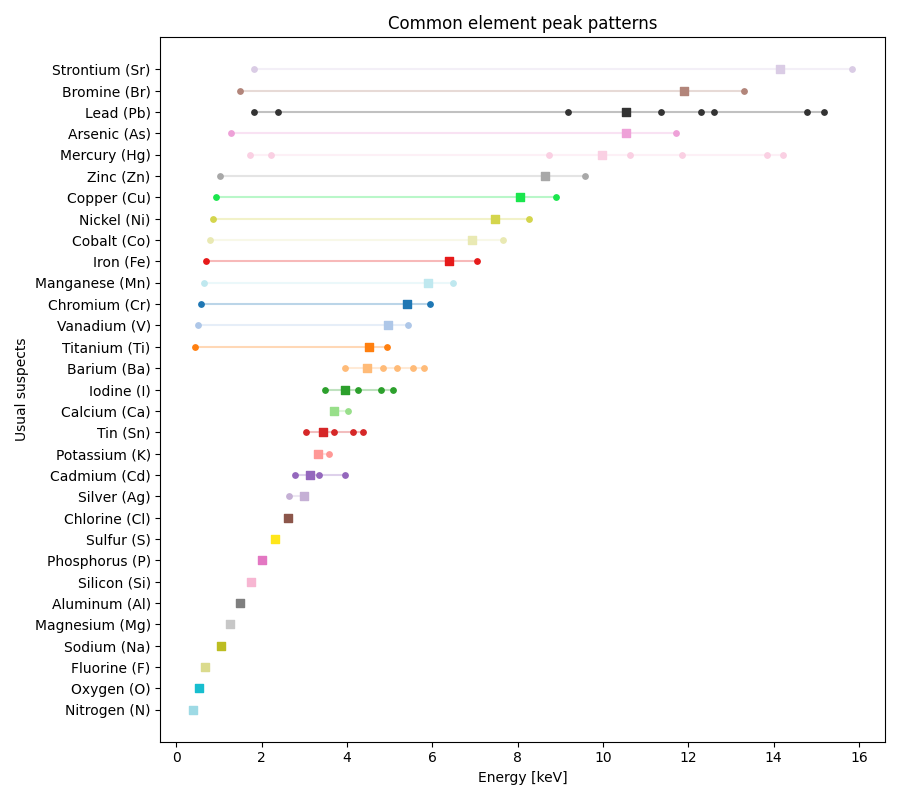

In [ ]:
ptrn_list = get_patterns(eoi)
plot_patterns(ptrn_list)

In [ ]:
ptrn_list

[{'elem': 'N',
  'peaks_xy': array([[0.3961981, 1.       ]]),
  'color': [0.6196078431372549, 0.8549019607843137, 0.8980392156862745]},
 {'elem': 'O',
  'peaks_xy': array([[0.52826413, 1.        ]]),
  'color': [0.09019607843137255, 0.7450980392156863, 0.8117647058823529]},
 {'elem': 'F',
  'peaks_xy': array([[0.67133567, 1.        ]]),
  'color': [0.8588235294117647, 0.8588235294117647, 0.5529411764705883]},
 {'elem': 'Na',
  'peaks_xy': array([[1.04552276, 1.        ]]),
  'color': [0.7372549019607844, 0.7411764705882353, 0.13333333333333333]},
 {'elem': 'Mg',
  'peaks_xy': array([[1.25462731, 1.        ]]),
  'color': [0.7803921568627451, 0.7803921568627451, 0.7803921568627451]},
 {'elem': 'Al',
  'peaks_xy': array([[1.48574287, 1.        ]]),
  'color': [0.4980392156862745, 0.4980392156862745, 0.4980392156862745]},
 {'elem': 'Si',
  'peaks_xy': array([[1.73886943, 1.        ]]),
  'color': [0.9686274509803922, 0.7137254901960784, 0.8235294117647058]},
 {'elem': 'P',
  'peaks_xy': a

In [ ]:
def get_instrument_patterns(datastack_file, anode='Rh', prominence=0.35): 
    '''Create instrument peak pattern dictionaries for sensor peak and Compton and elastic anode peaks.'''
    
    ds = maxrf4u.DataStack(datastack_file)
    
    # read max spectrum 
    ds = maxrf4u.DataStack(datastack_file)
    x_keVs = ds.read(ds.MAXRF_ENERGIES)
    y_max = ds.read(ds.MAXRF_MAXSPECTRUM)

    # locate peaks in max spectrum 
    peak_indices, _ = ssg.find_peaks(y_max, prominence=prominence)
    peaks_x = x_keVs[peak_indices]
    
    # assumes first peak is (negative) sensor peak 
    sensor_keV = peaks[0] 
    
    sensor_ptrn = {'source': 'SENSOR', 
                   'peaks_xy': np.array([[sensor_keV, 1]])}
    
    # anode peak pattern (including Compton)
    rhodium_peaks_x = mos.XFluo('Rh', tube_keV=40).peak_energies 
    Rh
    
    
    #anode_ptrn = 
     
    return peaks_x
    
    

In [ ]:
datastack_file = 'RP-T-1898-A-3689.datastack'

In [ ]:
# Extract Compton peak keV from truncated sum spectrum 
ds = maxrf4u.DataStack(datastack_file)

y_sum = ds.read('maxrf_sumspectrum')
y_sum_without_sensor_peak = y_sum.copy()
y_sum_without_sensor_peak[x_keV < 1] = 0
Rh_Compton_i = np.argmax(y_sum_without_sensor_peak)
Rh_Compton_keV = x_keV[Rh_Compton_i]
Rh_Compton_keV

In [ ]:
rhodium_spectrum = mos.XFluo('Rh', tube_keV=40)

In [ ]:
rhodium_spectrum.peak_intensities

array([0.08118119, 1.        , 0.244193  , 0.04090913])

In [ ]:
rhodium_spectrum.peak_energies

array([ 2.70135068, 20.21010505, 22.71135568, 23.17158579])

In [ ]:
maxrf4u.RHODIUM_Ka

20.210105052526263

In [ ]:
peaks_x = get_instrument_patterns('RP-T-1898-A-3689.datastack')
peaks_x

array([-0.02864804,  0.53326082,  2.37953279,  2.62035087,  3.30266878,
        3.68396408,  4.00505485,  4.50675919,  4.84791815,  5.89146317,
        6.4032016 ,  7.06545133,  8.04879184,  8.65083705,  8.89165513,
        9.22277999, 10.55731354, 11.67109718, 12.6444036 , 14.46057331,
       14.80173226, 18.84546925, 20.21010505, 21.012832  ])

Let's plot these patterns...

In [ ]:
eoi

array(['N', 'O', 'F', 'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'K', 'Ca',
       'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'As', 'Br',
       'Sr', 'Ag', 'Cd', 'Sn', 'I', 'Ba', 'Hg', 'Pb'], dtype='<U3')

First we need to add the ANODE and SENSOR patterns. 

In [ ]:
ptrn_list

[{'elem': 'N', 'peaks_xy': array([[0.3961981, 1.       ]])},
 {'elem': 'O', 'peaks_xy': array([[0.52826413, 1.        ]])},
 {'elem': 'F', 'peaks_xy': array([[0.67133567, 1.        ]])},
 {'elem': 'Na', 'peaks_xy': array([[1.04552276, 1.        ]])},
 {'elem': 'Mg', 'peaks_xy': array([[1.25462731, 1.        ]])},
 {'elem': 'Al', 'peaks_xy': array([[1.48574287, 1.        ]])},
 {'elem': 'Si', 'peaks_xy': array([[1.73886943, 1.        ]])},
 {'elem': 'P', 'peaks_xy': array([[2.014007, 1.      ]])},
 {'elem': 'S', 'peaks_xy': array([[2.31115558, 1.        ]])},
 {'elem': 'Cl', 'peaks_xy': array([[2.61930965, 1.        ]])},
 {'elem': 'Ag',
  'peaks_xy': array([[2.98249125, 1.        ],
         [2.64132066, 0.03711157]])},
 {'elem': 'Cd',
  'peaks_xy': array([[3.13656828, 1.        ],
         [3.33466733, 0.54499009],
         [3.95097549, 0.04265699],
         [2.77338669, 0.03710945]])},
 {'elem': 'K',
  'peaks_xy': array([[3.31265633, 1.        ],
         [3.5877939 , 0.11613478]])},

Then, we need to start matching the peak patterns.  